In [1]:
# todo: check the model cfg: augmentations, policy

In [1]:
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from utils import parse_cfg, iou_vectorized, objectness_filter_and_nms, show_predictions
from darknet import Darknet

we also can remove bias due to bn
make_layers returns net_info as well. check whether it"s necessary
shortcut is using output[i-1] instead of x check whether works with x
NOTE THAT CONV BEFORE YOLO USES (num_classes filters) * num_anch
changing predictions in the nms loop make sure that it is not used later
not adding +1 in nms


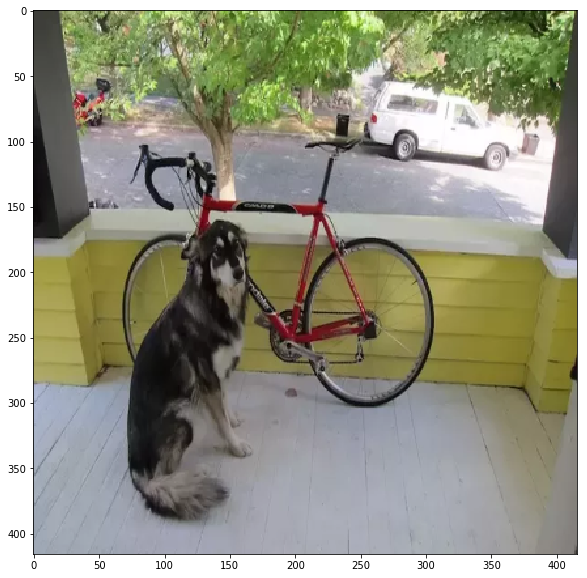

tensor(-7.5013, grad_fn=<MeanBackward1>)
tensor(-7.1436, grad_fn=<MeanBackward1>)


/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


tensor(-7.3534, grad_fn=<MeanBackward1>)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([4, 7])
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
make a proper resize for an image
make bboxes on image more pleasant


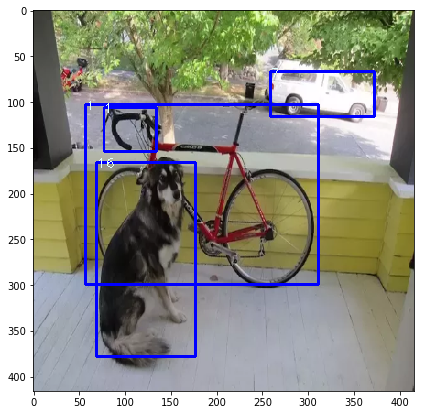

In [2]:
darknet = Darknet('cfg/yolov3_test_todel.cfg')

weight_file = 'weights/yolov3.weights'
darknet.load_weights(weight_file)
# darknet.eval()

from matplotlib import pyplot as plt
import cv2

plt.figure(figsize=(10, 10))

img = cv2.imread('dog-cycle-car.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (416, 416))
plt.imshow(img)
plt.show()
img = img.transpose((2, 0, 1))
img = torch.from_numpy(img).float()
img = img.unsqueeze(0)
pred = darknet(img, torch.device('cpu:0'))
# print('loading tensor')
# pred = torch.load('prediction.pt')
pred = objectness_filter_and_nms(pred, classes=80)
print(pred.shape)
show_predictions('dog-cycle-car.png', pred)